In [82]:
from pydub import AudioSegment
from pydub import effects
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#instead of taking each music value at each timestep, can use small sections of music values to run probability matrices for 
#use MLE to normal distribution parameters to the music sample and use that normal distribution as our acceptance function
#get 20 3 second clips from song 

random_starts = np.random.randint(120000, size=15)

random_clips = [AudioSegment.from_file("../music/cellophane.mp3", format="mp3")[clip+1000:clip+3500] for clip in random_starts]

# song = AudioSegment.from_file("../music/xxintro.mp3", format="mp3")[four_seconds:seven_seconds]

In [83]:
#spawn new sound clip given array
def spawn_clip(sound, array):
    return sound._spawn(array)

In [84]:
array = random_clips[0]

new_sound = spawn_clip(random_clips[0], random_clips[0].get_array_of_samples())
new_sound

In [85]:
def metropolis_hastings(proposal_func, init_func, acceptance_score, num_iters, step=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate samples and scorer to assign
    probability scores to samples.
      
    proposal_func -- function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func -- function that proposes starting
        state; takes no arguments and returns a
        sample state
    acceptance_score -- function that calculates the acceptance
        probability; takes in two state samples
        (candidate first, then sample) and returns
        acceptance probability
    
    Returns a sequence of every step-th sample. You 
    should only sample on upon acceptance of a new
    proposal. Do not keep sampling the current state.
    
    Note the total number of samples will NOT be
    equal to num_iters. num_iters is the total number
    of proposals we generate.
    """
    samples = []
    sample = init_func()
    for i in range(num_iters):
        candidate = proposal_func(sample)
        acceptance_ratio = min(1, acceptance_score(candidate,sample))
        if np.random.uniform() < acceptance_ratio:
            sample = candidate
            samples.append(sample)
    return samples[::step]

In [86]:
def starting_state():
    """
    Start with a random permutation.
    """
    return np.random.randint(0,45,25)

def sample_candidate(sample):
    """
    To search for new ciphers, randomly
    swap two letters in the previous cipher.
    """
    num_permute = 4 #hyperparameter
    sample = list(sample)
    for _ in range(num_permute):
        sample[np.random.randint(0,25)] = np.random.randint(0,45)
    return sample
    

def make_acceptance_scorer(transition_matrix):
    """
    Calculate the acceptance probability, which is the
    probability of observing the message translated by
    the proposed cipher divided by the probability of
    obseving the message translated by the current
    cipher.
    """
    
    def scorer(candidate, sample):
        nonlocal transition_matrix
        
        p_cand = 1
        for i in range(len(candidate) - 1):
            if transition_matrix[candidate[i]][candidate[i + 1]] != 0:
                p_cand *= transition_matrix[candidate[i]][candidate[i + 1]]
            
            
        p_samp = 1
        for i in range(len(sample) - 1):
            if transition_matrix[candidate[i]][candidate[i + 1]] != 0:
                p_samp *= transition_matrix[sample[i]][sample[i + 1]]
            
        return p_cand / p_samp
    
    return scorer

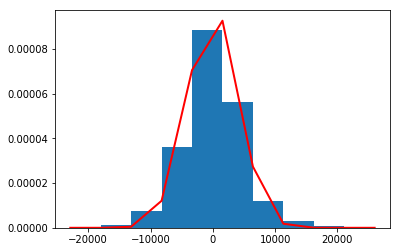

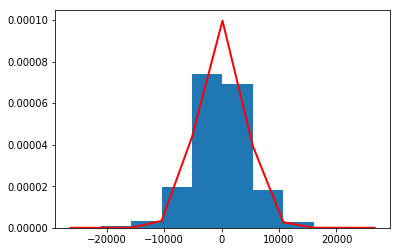

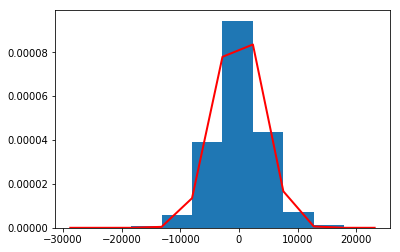

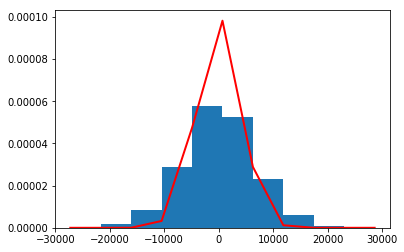

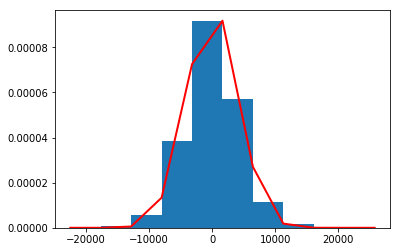

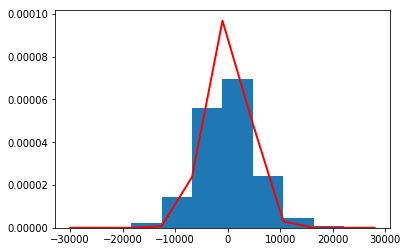

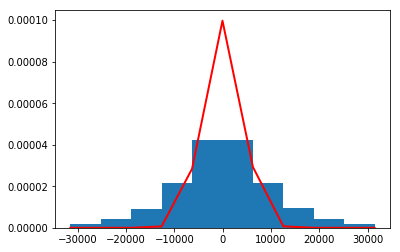

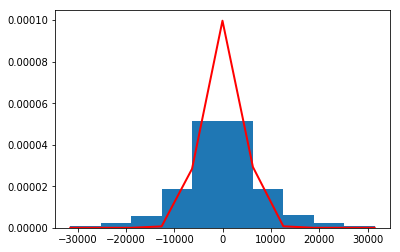

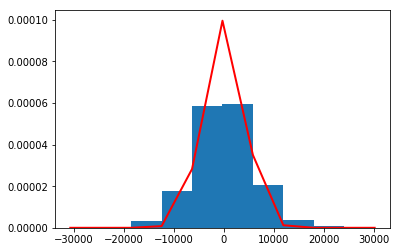

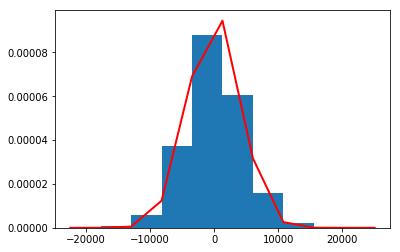

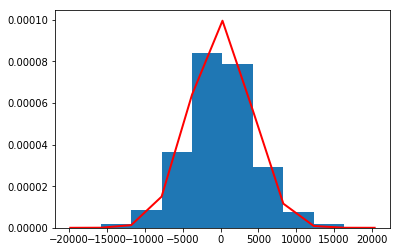

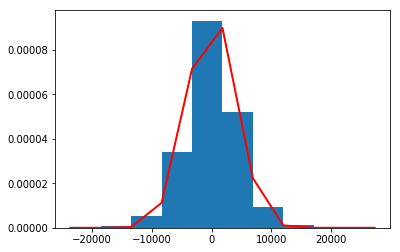

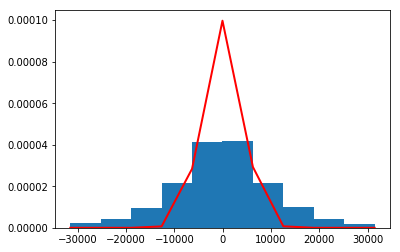

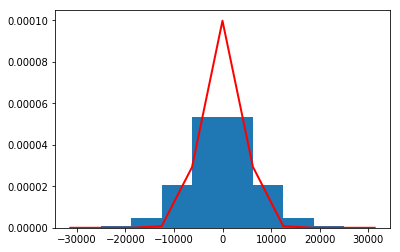

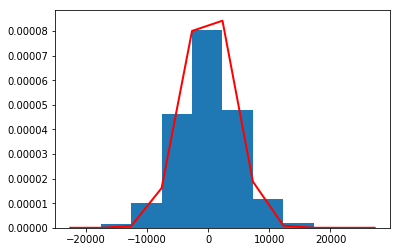

In [87]:
mu = 0
sigma = 4000

for clip in random_clips:
    arr = clip.get_array_of_samples()
    
    count, bins, ignored = plt.hist(arr, normed=True)
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
    plt.show()

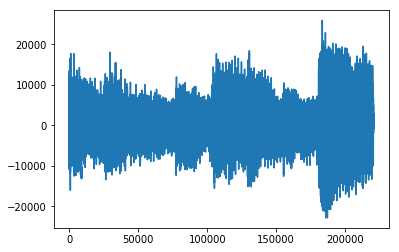

[1226, 3372]


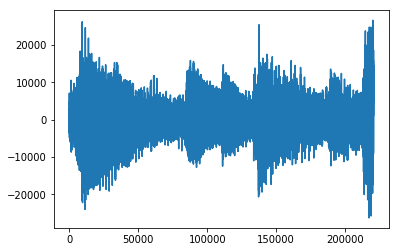

[9702, 11959]


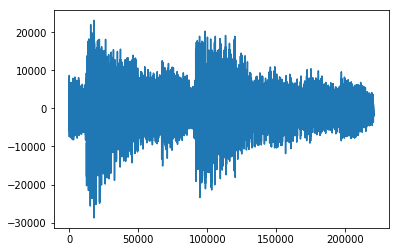

[3154, 4142]


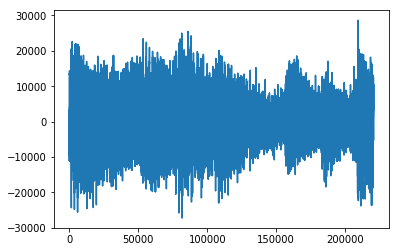

[2219, 5827]


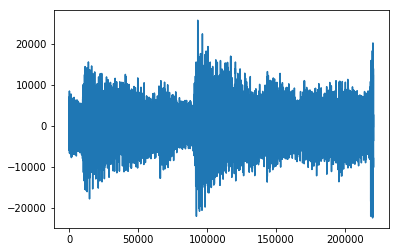

[9993, 10008]


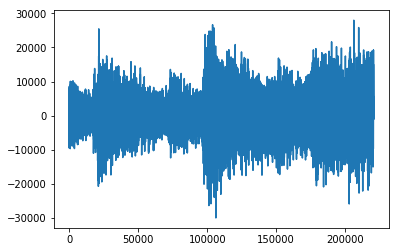

[1373, 3802]


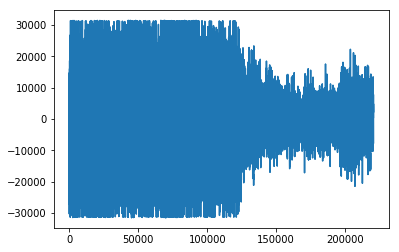

[1454, 2812]


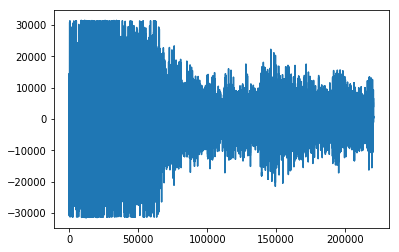

[5178, 11233]


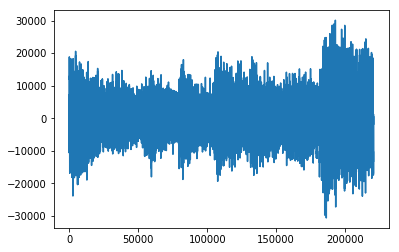

[1938, 2727]


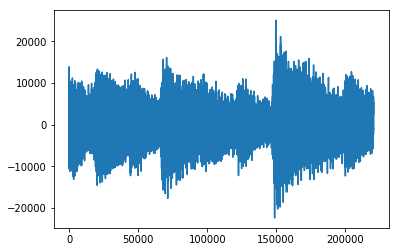

[2700, 3254]


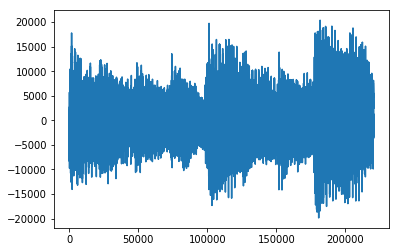

[5998, 6002]


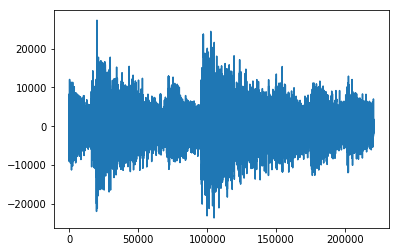

[1686, 2570]


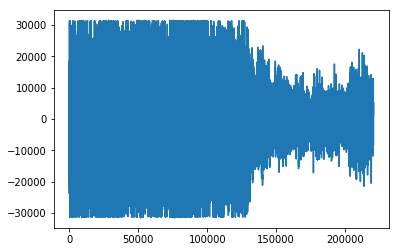

[4754, 9250]


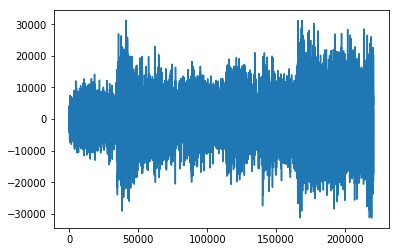

[7568, 10572]


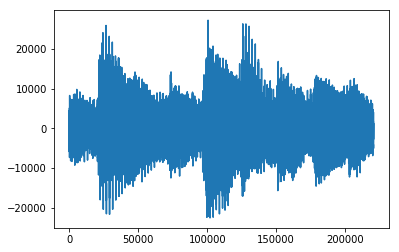

[4074, 5534]
45


In [88]:
#Method 1 for creating music note groupings - try and find sudden changes in notes to capture each note

note_dictionary1 = {}
i = 0
for clip in random_clips:
    arr = clip.get_array_of_samples()
    plt.plot(arr)
    plt.show()

    test_array = clip.get_array_of_samples()
    diff_array = [abs(abs(test_array[i+1]) - abs(test_array[i])) for i in range(len(test_array) - 1)]
    #print(np.array(diff_array).argsort()[::-1])
    
    storedVals = []
    divPoints = []

    for x in np.array(diff_array).argsort()[::-1]:
        if str(x)[0] not in storedVals and x > 1000 and x < 12000:
            storedVals.append(str(x)[0])
            divPoints.append(x)
    shortList = divPoints[:2]
    shortList.sort()
    print(shortList)

    
    note_dictionary1[str(i)] = test_array[0:shortList[0]]
    note_dictionary1[str(i+1)] = test_array[shortList[0]:shortList[1]]
    note_dictionary1[str(i +2)] = test_array[shortList[1]:]
    i += 3
    # print(test_array[3800:4100])
    spawn_clip(clip, arr[7438:])

    
print(len(note_dictionary1))

220500


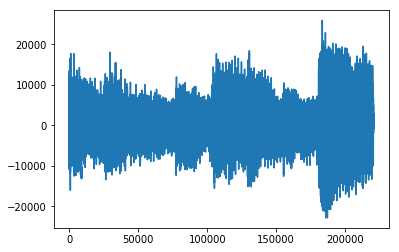

220500


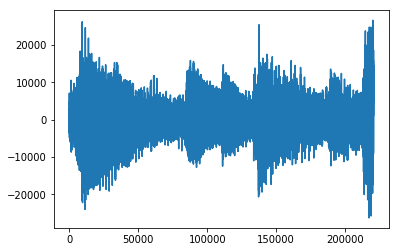

220500


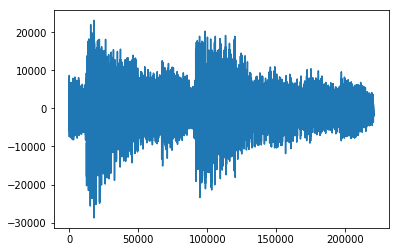

220500


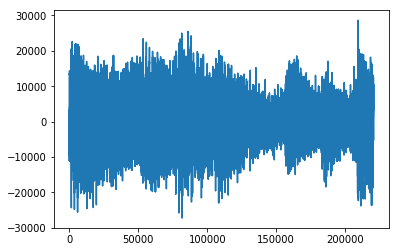

220500


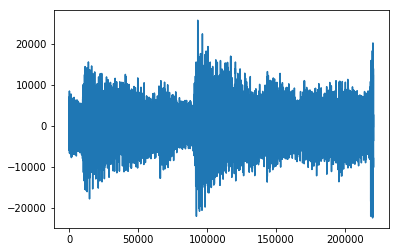

220500


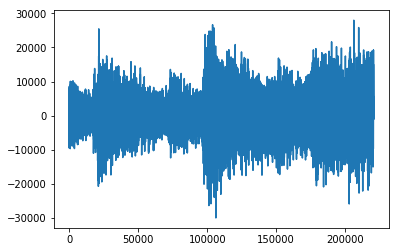

220500


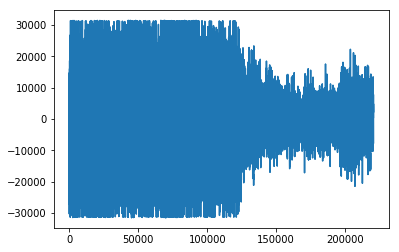

220500


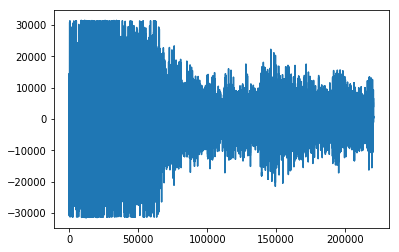

220500


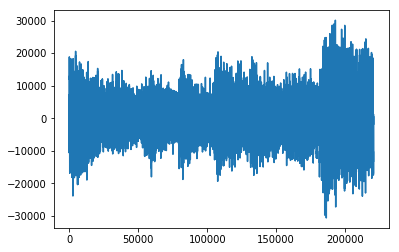

220500


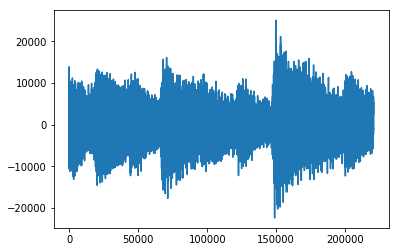

220500


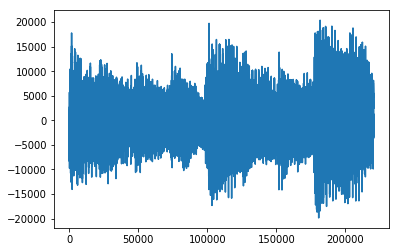

220500


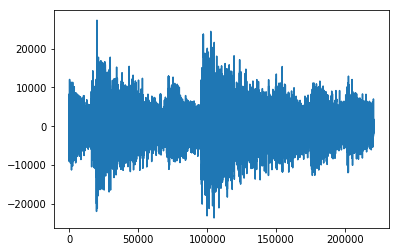

220500


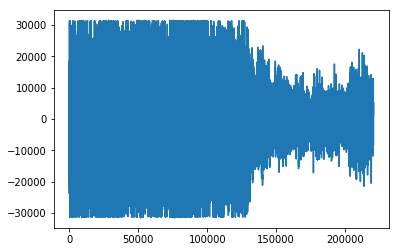

220500


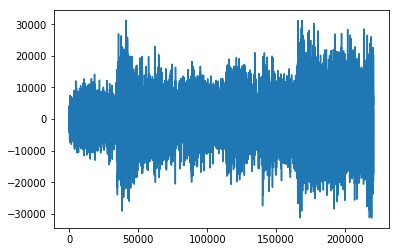

220500


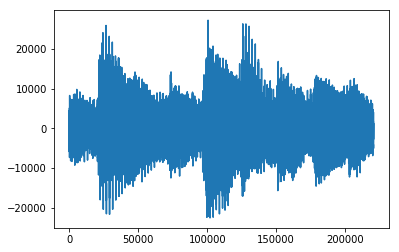

In [89]:
note_dictionary2 = {}
i = 0
for clip in random_clips:
    arr = clip.get_array_of_samples()
    arrayLen = len(arr)
    print(arrayLen)
    plt.plot(arr)
    plt.show()

    test_array = clip.get_array_of_samples()
    
    note_dictionary2[str(i)] = test_array[0:73500]
    note_dictionary2[str(i+1)] = test_array[73500:73500*2]
    note_dictionary2[str(i +2)] = test_array[73500*2:73500*3]
    i += 3
    # print(test_array[3800:4100])
    spawn_clip(clip, arr[7438:])

3.49471333612e-08


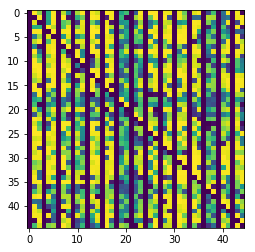

In [90]:
def generate(n, note_dict):
    shape = (n, n)
    mat = np.zeros(shape)
    
    arr = []
    
    for i in range(n-1):
        for j in range(n):
            if not(i % 3 == 2 or j == i+1):
                sim = similarity(note_dict[str(j)], note_dict[str(i)])
                arr.append(sim)
                mat[j][i+1] = sim 
    
    for i in range(n):
        if i % 3 != 2:
            mat[i][i+1] = 1
    
    max_small = max(arr)
    print(max_small)
    
    for i in range(n):
        for j in range(n):
            if mat[i][j] < 1:
                mat[i][j] /= max_small
                mat[i][j] = abs(mat[i][j])
                mat[i][j] = normalize(mat[i][j])
    
    return mat

def similarity(arr1, arr2):
    l1 = len(arr1)
    l2 = len(arr2)
    
    if l1 < l2:
        arr1.extend([0 for _ in range(l2-l1)])
    elif l1 > l2:
        arr2.extend([0 for _ in range(l1-l2)])

    dot = np.dot(arr1, arr2)
    normalization = np.linalg.norm(arr1) * np.linalg.norm(arr2)
    return dot / normalization

#0 to 1 -> push closer to 1
def normalize(x):
    return 2.0 / (1 + np.exp(-13 * x)) - 1
mat = generate(len(note_dictionary1), note_dictionary2)
plt.imshow(mat)

In [91]:
# aveClips = np.sum([clip.get_array_of_samples() for clip in random_clips], axis=0)/20
# print(aveClips)
# spawn_clip(random_clips[9], aveClips)

Task List

probability of 1 for given data indexes above that we know are right after each other but then have to construct a decreasing function with respect to increasing L2 distance for all indexes to every other index and its known next data value 

For example, say we know that index 2 follows index 1 with probability 1 from the data, then we would take the index i for all i, measure the distance from index 1's vector to that of index i's vector and based on how far these vectors are, assign a probability to the transition from index i to index 2. The larger the distance from index 1, the smaller the probability of that transition should be

1. Split up 3 second music signals into effective groupings based on amplitude changes
2. Create dictionary mapping between our grouping index and array of music signal values of grouping
3. Further the L2 norm of grouping signal value array is from another array, it will have a smaller probability value of transitioning to the next array that the other array goes to. The other array has a probability of 1 of transitioning to the next music grouping 
4. In the end we do MCMC with just the integers representing the music groupings 
5. Add normal distribution (parameters found through MLE) to add to the acceptance function to make sure all values of music array being created is still normal - might be implied since we are doing MCMC over index integers

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in double_scalars


[35, 10, 11, 14, 21, 38, 9, 2, 26, 7, 15, 5, 8, 13, 41, 43, 35, 42, 1, 42, 15, 28, 18, 39, 9]


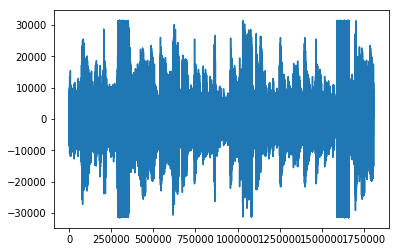

In [92]:
import array

def mostFrequent():
    #create function to see what sample from the MCMC occurs most frequently
    pass

scorer = make_acceptance_scorer(mat)
samples = metropolis_hastings(sample_candidate, starting_state, scorer, 10000)

print(samples[-1])
finalArray = samples[-1]

finalMusic = []

for note in finalArray:
    finalMusic += note_dictionary2[str(note)]

b = [x for x in finalMusic if abs(x) > 100]
plt.plot(b)
spawn_clip(new_sound, array.array('h', b))


<class 'array.array'>


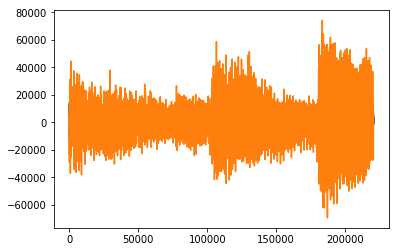

In [93]:
#Attempt to do a running average of music signal

arr = new_sound.get_array_of_samples()
averageVals = []

for i in range(0,len(arr)-50,50):
    sumTotal = np.sum(arr[i:i + 50])
    averageVals += [sumTotal/50] * 50

averageVals = [v*4 for v in averageVals]
plt.plot(arr)
print(type(arr))
plt.plot(averageVals)
spawn_clip(new_sound, arr)
spawn_clip(new_sound, averageVals)